In [1]:
from estimador import *
from filtros import *
from fit_voc import *
from functions import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

### Definimos el modelo

In [2]:
param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    Qmax=4.850,
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=864,
    adapt_cell=True,
    degradation_percentage=0.8
)
f_adap = FiltrosAnidados()
f_adap.Q_inst = param.get("Qmax")
f_adap.fit_batt_model(param)
f_adap.modelo_th.fit_inverse()
f_adap.voc_thresh = 0.05
f_adap.voc_times = 47
f_adap.sigma_autonomia = 0.04
f_adap.sigma_capacidad = 0.001 * 5
f_adap.estim_kwargs = {"sigma_e": 0.00075}

if f_adap.modelo_th.parameters["adapt_cell"]:
    f_adap.modelo_th.adapt_degradation()
    f_adap.modelo_th.setup_knn()
    print("celda: f_adap adaptada")

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [1.00000266], '75-0': [1.0000186], '100-50': [0.99999203], '75-25': [1.00001521], '50-0': [1.00002874], '100-75': [1.00002146], '75-50': [1.00000881], '62.5-37.5': [1.0000062], '50-25': [1.00003347], '25-0': [1.00004184]}
Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.85,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0],
                      '100-25': [1.00000266],
                      '100-50': [0.99999203],
                      '100-75': [1.00002146],
                      '25-0': [1.00004184],
                      '50-0': [1.00002874],
                      '50-25': [1.00003347],
                     

### Corremos el modelo

In [3]:
upper_soc = 0.8
lower_soc = 0.2
captotal = 4.850 # Ah
current = 4.850
dt = 36 # seg
total_deg = 2000

## Actualizamos la capacidad máxima de cada modelo
f_adap.Q_inst = 4.850 * 0.98 + np.random.normal(0,0.015)

## Iniciamos las variables del modelo
## Variables globales
current_deg = 1
cycles = []
Q_healthy = 4.850

## Variables método eq_cycle
dsoc_adap = 0
soc_acc_adap = 0
soc_inst_eqcycle_adap = upper_soc*100 + np.random.normal(0,0.005)*100*36
soc_counting_eqcycle_adap = [soc_inst_eqcycle_adap]  # Initialize soc_counting list
eqcycle_SoH_values_adap = [f_adap.Q_inst/Q_healthy]

deg_cycles = {}

while current_deg <= total_deg:
    # Iterating through all the datasets
    while f_adap.Q_inst > (0.8*Q_healthy):
        
        if soc_inst_eqcycle_adap < lower_soc:
            soc_inst_eqcycle_adap = 0.8

        # hacemos conteo de coulomb
        noise = np.random.normal(0,0.005)*100
        dsoc_adap = (dt * (-current) / (f_adap.Q_inst * 36)) + (noise)
        
        # actualizamos el soc
        soc_inst_eqcycle_adap += dsoc_adap

        if soc_inst_eqcycle_adap >= 100:
            soc_inst_eqcycle_adap = 100
        elif soc_inst_eqcycle_adap < 0:
            soc_inst_eqcycle_adaps = 0
        
        ## implementación metodo eqcycle
        if dsoc_adap < 0:
            soc_acc_adap += dsoc_adap
        soc_counting_eqcycle_adap.append(soc_inst_eqcycle_adap)
        if -100 >= soc_acc_adap:
            eta_k_eqcycle_adap = f_adap.get_factor(soc_counting_eqcycle_adap,unnml=False)
            f_adap.Q_inst *= eta_k_eqcycle_adap[0]
            eqcycle_SoH_values_adap.append(f_adap.Q_inst / Q_healthy)
            soc_acc_adap = 0
            soc_counting_eqcycle_adap = []

        # actualización de SoH por método
        
    deg_cycles[str(current_deg)] = eqcycle_SoH_values_adap
    f_adap.Q_inst = 4.850 * 0.98 + np.random.normal(0,0.015)
    eqcycle_SoH_values_adap = []
    soc_inst_eqcycle_adap = 0.8 + np.random.normal(0,0.005)*100*36
    print(f"{current_deg}", end='\r')
    current_deg += 1

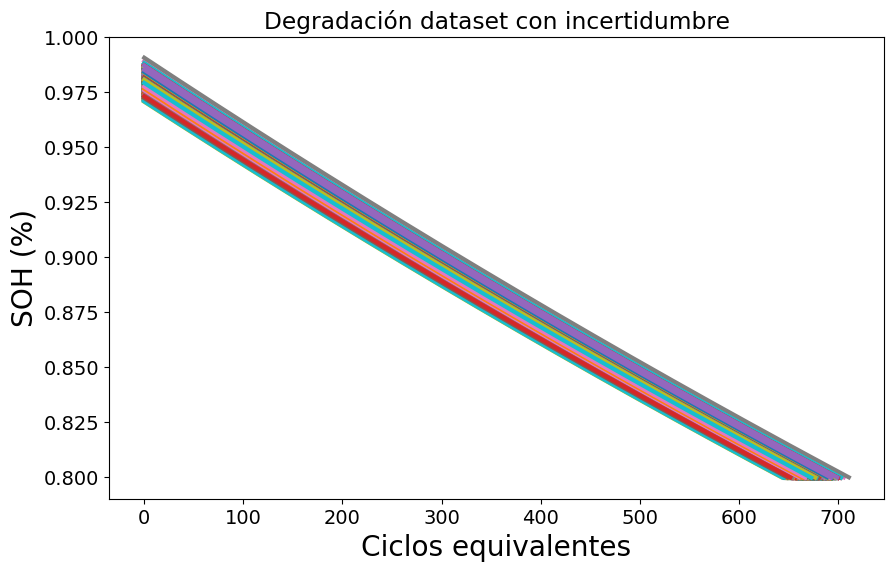

In [43]:
plt.figure(figsize=(10, 6))
for key, values in deg_cycles.items():
    plt.plot(values)
plt.title("Degradación dataset con incertidumbre")
plt.xlabel("Ciclos equivalentes")
plt.ylabel("SOH (%)")
# plt.ylim(())
# plt.legend()
fig_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/degradation_curves.pdf"
plt.savefig(fig_path)
plt.show()

In [5]:
filename = 'MC_degradation_model_uncer_SOH_SOC.csv'

# Find the length of the longest list in the dictionary
max_len = max(len(v) for v in deg_cycles.values())

# Open the file for writing
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(deg_cycles.keys())

    # Write the data row by row
    for i in range(max_len):
        row = []
        for key in deg_cycles:
            # Append the value if it exists, otherwise append an empty string
            row.append(deg_cycles[key][i] if i < len(deg_cycles[key]) else '')
        writer.writerow(row)

print(f"Data saved to {filename}")

Data saved to MC_degradation_model_uncer_SOH_SOC.csv


In [6]:
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/MC_degradation_model_uncer_SOH_SOC.csv"
SOH_values = pd.read_csv(path)
SOH_values

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,0.980360,0.973073,0.987064,0.982453,0.976393,0.982659,0.980509,0.975855,0.975439,0.975474,...,0.983985,0.976441,0.978734,0.980178,0.985001,0.979123,0.977393,0.980457,0.980368,0.979024
1,0.980102,0.972780,0.986768,0.982158,0.976100,0.982364,0.980214,0.975562,0.975146,0.975181,...,0.983690,0.976148,0.978440,0.979884,0.984705,0.978829,0.977099,0.980163,0.980074,0.978730
2,0.979807,0.972488,0.986472,0.981863,0.975807,0.982068,0.979920,0.975269,0.974853,0.974888,...,0.983394,0.975854,0.978146,0.979589,0.984410,0.978535,0.976806,0.979868,0.979779,0.978436
3,0.979513,0.972196,0.986176,0.981568,0.975514,0.981773,0.979625,0.974976,0.974560,0.974595,...,0.983099,0.975561,0.977852,0.979295,0.984114,0.978241,0.976512,0.979574,0.979485,0.978142
4,0.979219,0.971904,0.985880,0.981273,0.975221,0.981479,0.979331,0.974684,0.974267,0.974303,...,0.982804,0.975268,0.977558,0.979001,0.983818,0.977947,0.976219,0.979279,0.979191,0.977848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


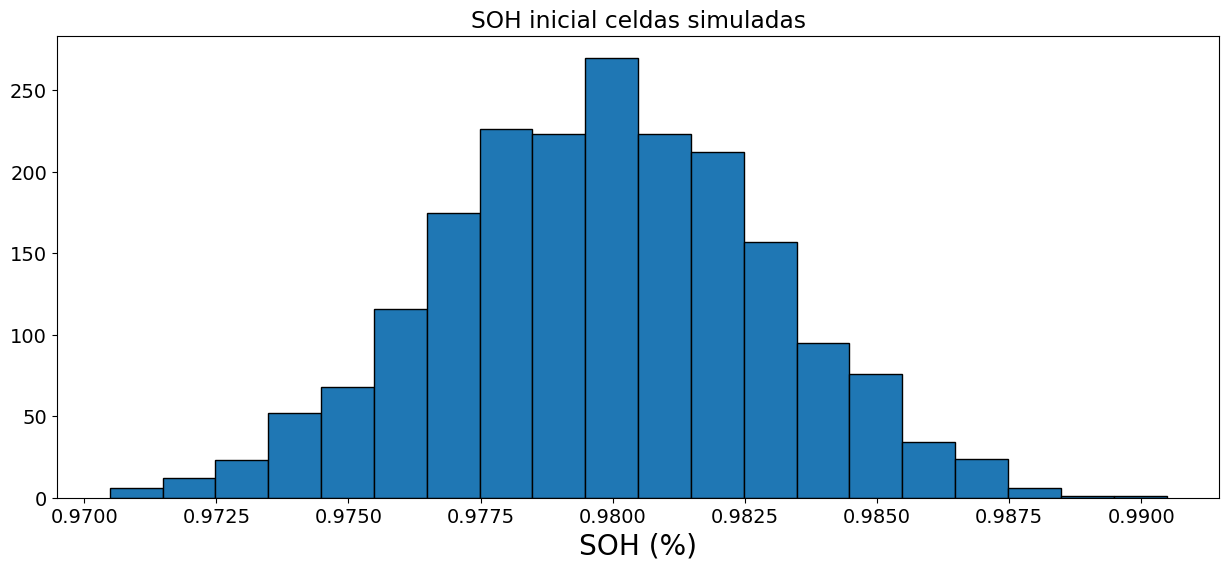

In [44]:
SOH_085 = []
cycle_085 = []

for column in SOH_values.columns:
    values = SOH_values[column]
    SOH_085.append(values[0])

# print(SOH_085)
# rango = max(cycle_085) - min(cycle_085)


plt.figure(figsize=(15, 6))
plt.hist(SOH_085,bins=20,edgecolor='black')
plt.title("SOH inicial celdas simuladas")
plt.xlabel("SOH (%)")
# plt.ylabel("SOH(%)")
# plt.legend()
fig_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/initial_SOH.pdf"
plt.savefig(fig_path)

plt.show()



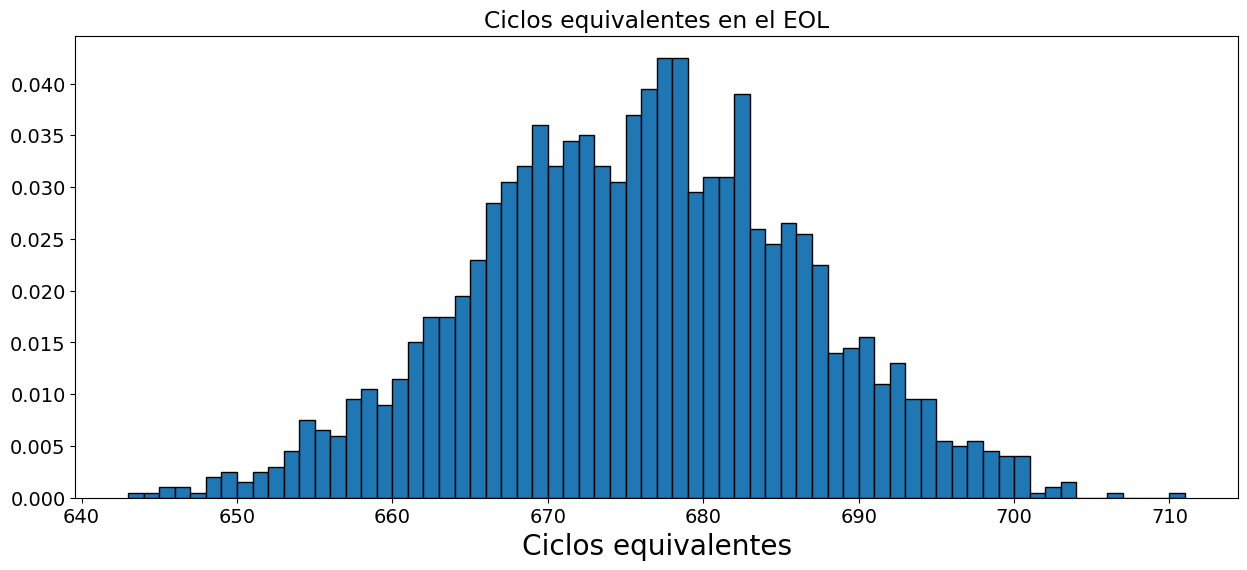

In [48]:
SOH_085 = []
cycle_085 = []

for column in SOH_values.columns:
    values = SOH_values[column]
    cycle_085.append(values.last_valid_index())

# print(SOH_085)
rango = max(cycle_085) - min(cycle_085)


plt.figure(figsize=(15, 6))
plt.hist(cycle_085, bins= rango, edgecolor='black', density=True)
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.title("Ciclos equivalentes en el EOL")
plt.xlabel("Ciclos equivalentes")
# plt.ylabel("SOH(%)")
# plt.legend()
fig_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/EOL_cycles.pdf"
plt.savefig(fig_path)
plt.show()

In [9]:
import statistics

# Calculate the mean
mean_value = statistics.mean(cycle_085)

# Calculate the standard deviation
std_value = statistics.stdev(cycle_085)

print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_value}")

Mean: 675.2585
Standard Deviation: 10.507039387398535
